# **1. Download data and install packages**

In [1]:
!gdown 1QEbk-ELdmjEpmFcWyYnOQwd0DRr9eL2G

Downloading...
From (original): https://drive.google.com/uc?id=1QEbk-ELdmjEpmFcWyYnOQwd0DRr9eL2G
From (redirected): https://drive.google.com/uc?id=1QEbk-ELdmjEpmFcWyYnOQwd0DRr9eL2G&confirm=t&uuid=344dd257-9eac-4c32-8532-d2ef21eab735
To: /content/mit_bih_data.csv
100% 765M/765M [00:13<00:00, 56.7MB/s]


In [2]:
!pip -qq install PyWavelets
!pip -qq install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.4 MB/s eta 0:00:00


# **2. Importing libraries and data**

In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pywt # For wavelet transform
from pyts.image import MarkovTransitionField # For Markov Transition Field

In [4]:
# First 271 cols contain data, Last col contains class (5 different classes)
df = pd.read_csv('./mit_bih_data.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
0,0.588844,0.588654,0.588334,0.587855,0.587206,0.586394,0.585464,0.584492,0.583573,0.582812,...,0.581103,0.581080,0.581053,0.581026,0.580996,0.580946,0.580866,0.580745,0.580595,0.0
1,0.578133,0.577636,0.577092,0.576522,0.575956,0.575431,0.574974,0.574603,0.574331,0.574159,...,0.579950,0.579893,0.579956,0.580128,0.580379,0.580662,0.580920,0.581086,0.581096,0.0
2,0.573414,0.572866,0.572233,0.571576,0.570973,0.570499,0.570210,0.570125,0.570227,0.570463,...,0.585479,0.585485,0.585377,0.585168,0.584886,0.584562,0.584228,0.583907,0.583619,0.0
3,0.577282,0.577243,0.577355,0.577547,0.577735,0.577841,0.577800,0.577572,0.577153,0.576572,...,0.581164,0.581510,0.581999,0.582616,0.583305,0.583991,0.584573,0.584963,0.585090,0.0
4,0.576740,0.576704,0.576705,0.576707,0.576683,0.576618,0.576515,0.576386,0.576264,0.576167,...,0.586527,0.586918,0.587336,0.587758,0.588162,0.588520,0.588796,0.588948,0.588941,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112497,0.428762,0.427685,0.426598,0.425531,0.424482,0.423434,0.422382,0.421346,0.420375,0.419542,...,0.426686,0.427223,0.428053,0.429110,0.430266,0.431346,0.432168,0.432584,0.432518,0.0
112498,0.434033,0.434040,0.434087,0.434045,0.433790,0.433248,0.432413,0.431352,0.430186,0.429057,...,0.428152,0.426986,0.426260,0.426087,0.426461,0.427260,0.428275,0.429270,0.430037,0.0
112499,0.433764,0.433542,0.433291,0.432878,0.432264,0.431493,0.430688,0.430014,0.429629,0.429635,...,0.420577,0.421564,0.422542,0.423309,0.423729,0.423750,0.423427,0.422894,0.422332,0.0
112500,0.424160,0.424108,0.423675,0.422888,0.421871,0.420816,0.419940,0.419422,0.419369,0.419788,...,0.424047,0.424681,0.425568,0.426517,0.427351,0.427951,0.428280,0.428385,0.428369,0.0


# **3. Data preprocessing and Train test split**

In [5]:
from sklearn.model_selection import train_test_split

X, y = df.to_numpy()[:,:-1], df.to_numpy()[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
print(X_train.shape)
print(X_test.shape)

(90001, 271)
(22501, 271)


In [7]:
class MLDataset(Dataset):
    def __init__(self, is_train=True):
      if is_train:
        self.data = X_train
        self.label = y_train
      else:
        self.data = X_test
        self.label = y_test

      ### Wavelet transform
      self.wavelet = "cmor2.5-1.5"
      self.fs = 360  # Sampling frequency from the database

      self.downsampling_data = [sample[::6] for sample in self.data] # Downsampling to 6 times to speed up processing
      self.widths = np.arange(1, self.fs/6+1)[::-1]  # Width for the wavelet transform
      self.wavelet_data = [np.abs(pywt.cwt(sample, self.widths, self.wavelet)[0]) for sample in self.downsampling_data]

      ### Markov Transition field
      self.mtf = MarkovTransitionField(n_bins=10)  # Use 10 different states (bins) to for markov transtion counting
      self.markov_data = [self.mtf.fit_transform(sample.reshape(1, -1))[0] for sample in self.downsampling_data]

    def __getitem__(self, index):
      ### Time data
      time_record_tensor = torch.from_numpy(self.data[index]).float()

      ### Wavelet
      # Expand dims 0 to consider it as a gray image
      wavelet_tensor = torch.from_numpy(np.expand_dims(self.wavelet_data[index], axis=0)).float()

      ### Markov Transition field
      # Expand dims 0 to consider it as a gray image
      markov_tensor = torch.from_numpy(np.expand_dims(self.markov_data[index], axis=0)).float()

      ### Label processing
      # One hot encoding for label
      label_tensor = torch.zeros(5).float() # Initialize a tensor of zeros with length 5 (num_classes=5)
      label_tensor[int(self.label[index])] = 1.0 # Set the element at the index of self.label[index] to 1

      return time_record_tensor, wavelet_tensor, markov_tensor, label_tensor


    def __len__(self):
      return len(self.data)

In [8]:
train_set = MLDataset(is_train=True)

BATCH_SIZE = 256
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equa

In [9]:
# Only run this once when finish training
test_set = MLDataset(is_train=False)

BATCH_SIZE = 256
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


In [10]:
# Remove from RAM and GPU memory
# del train_set, train_dataloader
# del test_set, test_dataloader

tensor([1., 0., 0., 0., 0.])


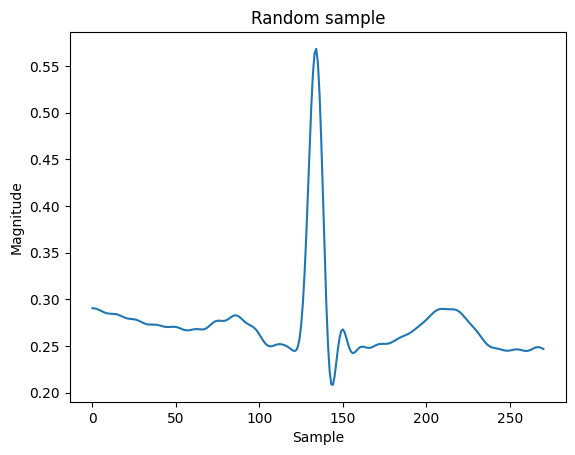

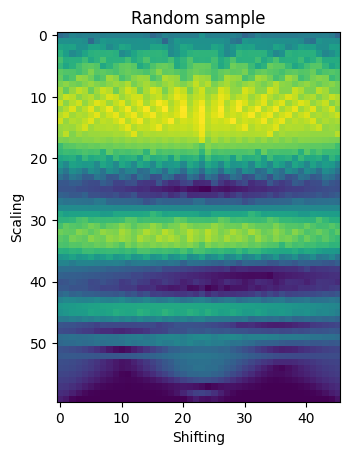

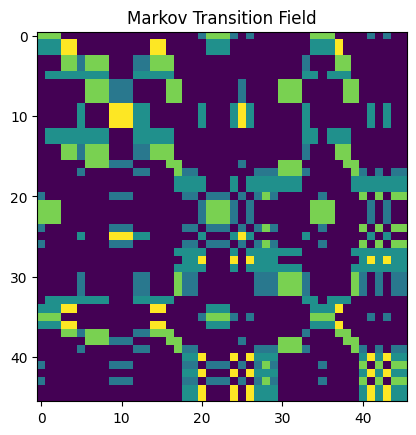

In [11]:
import matplotlib.pyplot as plt

for batch_time_record_tensor, batch_wavelet_tensor, batch_markov_tensor, batch_label_tensor in train_dataloader:
    index = np.random.randint(1, 64)

    print(batch_label_tensor[index])
    plt.plot(batch_time_record_tensor[index])
    plt.title("Random sample")
    plt.xlabel("Sample")
    plt.ylabel("Magnitude")
    plt.show()

    plt.imshow(batch_wavelet_tensor[index][0,:,:])
    plt.title("Random sample")
    plt.xlabel("Shifting")
    plt.ylabel("Scaling")
    plt.show()

    plt.imshow(batch_markov_tensor[index][0,:,:])
    plt.title("Markov Transition Field")
    plt.show()
    break

In [12]:
# Dimension check, batch_size = 64, data_length = 271, downsampling_data_length = 91
for batch_time_record_tensor, batch_wavelet_tensor, batch_markov_tensor, batch_label_tensor in train_dataloader:
    print(batch_time_record_tensor.shape)
    print(batch_wavelet_tensor.shape)
    print(batch_markov_tensor.shape)
    print(batch_label_tensor.shape)
    break

torch.Size([256, 271])
torch.Size([256, 1, 60, 46])
torch.Size([256, 1, 46, 46])
torch.Size([256, 5])


# **4. Proposed Learning Model**

In [13]:
# Testing for gpu
device = torch.device('cuda:0')

In [14]:
def conv_block(num_filter):
    dropout_rate = 0.1
    return nn.Sequential(
      nn.Conv2d(in_channels=num_filter, out_channels=num_filter, kernel_size=(1, 1), stride=1, padding=(0, 0)),
      nn.BatchNorm2d(num_features=num_filter),
      nn.Dropout(dropout_rate),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_filter, out_channels=num_filter, kernel_size=(3, 3), stride=1, padding=(1, 1)),
      nn.BatchNorm2d(num_features=num_filter),
      nn.Dropout(dropout_rate),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_filter, out_channels=num_filter*4, kernel_size=(1, 1), stride=1, padding=(0, 0)),
      nn.BatchNorm2d(num_features=num_filter*4),
      nn.Dropout(dropout_rate),
      nn.ReLU(),
    )

class ProposedModel(nn.Module):
  def __init__(self, num_classes):
    super(ProposedModel, self).__init__()

    """
    Time record flow
    """
    self.fully_connected0 = nn.Sequential(
      nn.Linear(in_features=271, out_features=4096),
      nn.BatchNorm1d(num_features=4096),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=4096, out_features=4096),
      nn.BatchNorm1d(num_features=4096),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=4096, out_features=num_classes),  # num_classes = 5
      nn.BatchNorm1d(num_features=num_classes),
      nn.Dropout(0.1),
      nn.Softmax(dim=1),
    )
    """
    End of Time record flow
    """


    """
    Wavelet transform flow
    """
    self.block0 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=2, padding=(3, 3)),
      nn.BatchNorm2d(num_features=64),
      nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1)),
    )

    self.block1_filter_size = 64
    self.block1 = conv_block(num_filter=self.block1_filter_size)
    self.block1_projection = nn.Conv2d(in_channels=self.block1_filter_size,
                                       out_channels=self.block1_filter_size*4,
                                       kernel_size=(1, 1), stride=1, padding=(0, 0))

    self.block2_filter_size = 256
    self.block2_downsampling = nn.Conv2d(in_channels=self.block2_filter_size,
                                         out_channels=self.block2_filter_size,
                                         kernel_size=(1, 1), stride=2, padding=(0, 0))
    self.block2 = conv_block(num_filter=self.block2_filter_size)
    self.block2_projection = nn.Conv2d(in_channels=self.block2_filter_size,
                                       out_channels=self.block2_filter_size*4,
                                       kernel_size=(1, 1), stride=2, padding=(0, 0))

    self.fully_connected1 = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=1024*(8*6), out_features=4096),
      nn.BatchNorm1d(num_features=4096),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=4096, out_features=4096),
      nn.BatchNorm1d(num_features=4096),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=4096, out_features=num_classes),  # num_classes = 5
      nn.BatchNorm1d(num_features=num_classes),
      nn.Dropout(0.1),
      nn.Softmax(dim=1),
    )
    """
    End of Wavelet transform flow
    """


    """
    Markov Transition Field flow
    """
    self.block3 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=2, padding=(3, 3)),
      nn.BatchNorm2d(num_features=64),
      nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1)),
    )

    self.block4_filter_size = 64
    self.block4 = conv_block(num_filter=self.block1_filter_size)
    self.block4_projection = nn.Conv2d(in_channels=self.block1_filter_size,
                                       out_channels=self.block1_filter_size*4,
                                       kernel_size=(1, 1), stride=1, padding=(0, 0))

    self.block5_filter_size = 256
    self.block5_downsampling = nn.Conv2d(in_channels=self.block2_filter_size,
                                         out_channels=self.block2_filter_size,
                                         kernel_size=(1, 1), stride=2, padding=(0, 0))
    self.block5 = conv_block(num_filter=self.block2_filter_size)
    self.block5_projection = nn.Conv2d(in_channels=self.block2_filter_size,
                                       out_channels=self.block2_filter_size*4,
                                       kernel_size=(1, 1), stride=2, padding=(0, 0))

    self.fully_connected2 = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=1024*(6*6), out_features=4096),
      nn.BatchNorm1d(num_features=4096),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=4096, out_features=4096),
      nn.BatchNorm1d(num_features=4096),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=4096, out_features=num_classes),  # num_classes = 5
      nn.BatchNorm1d(num_features=num_classes),
      nn.Dropout(0.1),
      nn.Softmax(dim=1),
    )
    """
    End of Markov Transition Field flow
    """

  def forward(self, time_record_tensor, wavelet_tensor, markov_tensor):
    """
    Dimension reminder
    [64, 271]: batch_time_record_tensor_shape
    [64, 1, 120, 91]: batch_wavelet_tensor_shape
    [64, 1, 91, 91]: batch_markov_tensor_shape
    [64, 5]: batch_label_tensor_shape
    """

    """
    Time record flow
    """
    time_record_flow = self.fully_connected0(time_record_tensor)
    """
    End of Time record flow
    """


    """
    Wavelet flow
    """
    wavelet_flow = self.block0(wavelet_tensor)

    # Block 1
    identity = wavelet_flow
    wavelet_flow = self.block1(wavelet_flow)
    wavelet_flow = wavelet_flow + self.block1_projection(identity)

    # Block 2
    identity = wavelet_flow
    wavelet_flow = self.block2_downsampling(wavelet_flow)
    wavelet_flow = self.block2(wavelet_flow)
    wavelet_flow = wavelet_flow + self.block2_projection(identity)

    wavelet_flow = self.fully_connected1(wavelet_flow)
    """
    End of Wavelet flow
    """


    """
    Markov Transition Field flow
    """
    markov_flow = self.block3(markov_tensor)

    # Block 4
    identity = markov_flow
    markov_flow = self.block4(markov_flow)
    markov_flow = markov_flow + self.block4_projection(identity)

    # Block 5
    identity = markov_flow
    markov_flow = self.block5_downsampling(markov_flow)
    markov_flow = self.block5(markov_flow)
    markov_flow = markov_flow + self.block5_projection(identity)

    markov_flow = self.fully_connected2(markov_flow)
    """
    End of Markov Transition Field flow
    """

    """
    Merge flows
    """
    final_result = time_record_flow + wavelet_flow + markov_flow

    return final_result


from torchsummary import summary

try: # remove previous model when compiling failed
  del model
except:
  pass
model = ProposedModel(num_classes=5).to(device)
# summary(model, input_size=[(271,), (1, 60, 46), (1, 46, 46)])   # dimension debug

# Test for training model
for epoch in range(1):
  for idx, (time_record_tensor, wavelet_tensor, markov_tensor, label_tensor) in enumerate(train_dataloader):
    # Forward
    time_record_tensor = time_record_tensor.to(device)
    wavelet_tensor = wavelet_tensor.to(device)
    markov_tensor = markov_tensor.to(device)
    label_predict = model(time_record_tensor, wavelet_tensor, markov_tensor)
    label_tensor = label_tensor.type(torch.LongTensor).to(device)

    break

# **5. Loss function, Optimization Method and Model Training**

In [15]:
### Loss function and Optimization method
from torch import optim

# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimization method
learning_rate = 1e-3
weight_decay = 1e-4  # L2 Regularization
optimizer = optim.Adam(
    params=model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

In [16]:
### Training model
num_epochs = 20
epochs_loss = dict()

for epoch in range(num_epochs):
  for idx, (time_record_tensor, wavelet_tensor, markov_tensor, label_tensor) in enumerate(train_dataloader):
    # Forward
    time_record_tensor = time_record_tensor.to(device)
    wavelet_tensor = wavelet_tensor.to(device)
    markov_tensor = markov_tensor.to(device)
    label_predict = model(time_record_tensor, wavelet_tensor, markov_tensor)
    label_tensor = label_tensor.to(device)

    forward_loss = loss_function(label_predict, label_tensor)

    # Backward
    optimizer.zero_grad()
    forward_loss.backward()
    optimizer.step()

  epochs_loss[epoch+1] = forward_loss.item()
  print(f"epoch: {epoch+1}, loss = {forward_loss.item():.4f}")

epoch: 1, loss = 0.6856
epoch: 2, loss = 0.5007
epoch: 3, loss = 0.4222
epoch: 4, loss = 0.3739
epoch: 5, loss = 0.3794
epoch: 6, loss = 0.3310
epoch: 7, loss = 0.3032
epoch: 8, loss = 0.3067
epoch: 9, loss = 0.2834
epoch: 10, loss = 0.2864
epoch: 11, loss = 0.2612
epoch: 12, loss = 0.2519
epoch: 13, loss = 0.2583
epoch: 14, loss = 0.2292
epoch: 15, loss = 0.2513
epoch: 16, loss = 0.2561
epoch: 17, loss = 0.2487
epoch: 18, loss = 0.2604
epoch: 19, loss = 0.2453
epoch: 20, loss = 0.2369


In [33]:
### Further Training model
num_epochs = 5
epochs_loss = dict()

for epoch in range(num_epochs):
  for idx, (time_record_tensor, wavelet_tensor, markov_tensor, label_tensor) in enumerate(train_dataloader):
    # Forward
    time_record_tensor = time_record_tensor.to(device)
    wavelet_tensor = wavelet_tensor.to(device)
    markov_tensor = markov_tensor.to(device)
    label_predict = model(time_record_tensor, wavelet_tensor, markov_tensor)
    label_tensor = label_tensor.to(device)

    forward_loss = loss_function(label_predict, label_tensor)

    # Backward
    optimizer.zero_grad()
    forward_loss.backward()
    optimizer.step()

  epochs_loss[epoch+1] = forward_loss.item()
  print(f"epoch: {epoch+1}, loss = {forward_loss.item():.4f}")

epoch: 1, loss = 0.2335
epoch: 2, loss = 0.2383
epoch: 3, loss = 0.2244
epoch: 4, loss = 0.2290
epoch: 5, loss = 0.2232


In [43]:
### Further Training model
num_epochs = 5
epochs_loss = dict()

for epoch in range(num_epochs):
  for idx, (time_record_tensor, wavelet_tensor, markov_tensor, label_tensor) in enumerate(train_dataloader):
    # Forward
    time_record_tensor = time_record_tensor.to(device)
    wavelet_tensor = wavelet_tensor.to(device)
    markov_tensor = markov_tensor.to(device)
    label_predict = model(time_record_tensor, wavelet_tensor, markov_tensor)
    label_tensor = label_tensor.to(device)

    forward_loss = loss_function(label_predict, label_tensor)

    # Backward
    optimizer.zero_grad()
    forward_loss.backward()
    optimizer.step()

  epochs_loss[epoch+1] = forward_loss.item()
  print(f"epoch: {epoch+1}, loss = {forward_loss.item():.4f}")

epoch: 1, loss = 0.2224
epoch: 2, loss = 0.2249
epoch: 3, loss = 0.2390
epoch: 4, loss = 0.2288
epoch: 5, loss = 0.2305


In [49]:
### Further Training model
num_epochs = 10
epochs_loss = dict()

for epoch in range(num_epochs):
  for idx, (time_record_tensor, wavelet_tensor, markov_tensor, label_tensor) in enumerate(train_dataloader):
    # Forward
    time_record_tensor = time_record_tensor.to(device)
    wavelet_tensor = wavelet_tensor.to(device)
    markov_tensor = markov_tensor.to(device)
    label_predict = model(time_record_tensor, wavelet_tensor, markov_tensor)
    label_tensor = label_tensor.to(device)

    forward_loss = loss_function(label_predict, label_tensor)

    # Backward
    optimizer.zero_grad()
    forward_loss.backward()
    optimizer.step()

  epochs_loss[epoch+1] = forward_loss.item()
  print(f"epoch: {epoch+1}, loss = {forward_loss.item():.4f}")

epoch: 1, loss = 0.2420
epoch: 2, loss = 0.2287
epoch: 3, loss = 0.2353
epoch: 4, loss = 0.2222
epoch: 5, loss = 0.2317
epoch: 6, loss = 0.2254
epoch: 7, loss = 0.2338
epoch: 8, loss = 0.2334
epoch: 9, loss = 0.2195
epoch: 10, loss = 0.2379


# **6. Model Evaluation**

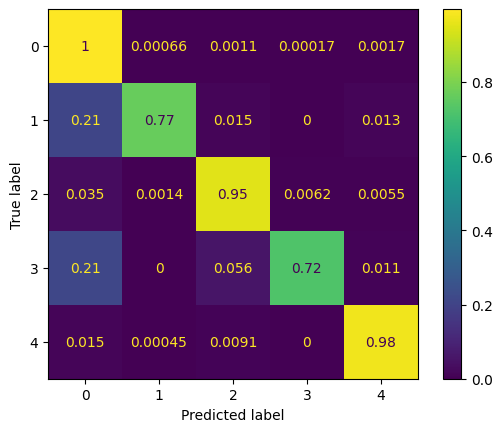

In [57]:
# Model inference and display Confusion Matrix
predicts = []

for time_record_tensor, wavelet_tensor, markov_tensor, label_tensor in test_dataloader:
    time_record_tensor = time_record_tensor.cuda()
    wavelet_tensor = wavelet_tensor.cuda()
    label_tensor = label_tensor.cuda()
    markov_tensor = markov_tensor.cuda()

    label_predict = model(time_record_tensor, wavelet_tensor, markov_tensor).cuda()
    predicts.extend(np.argmax(label_predict.cpu().detach().numpy(), axis=1))



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels_names = ["N", "S", "V", "F", "Q"]
cm = confusion_matrix(y_test, predicts, normalize='true')
ConfusionMatrixDisplay(cm).plot()

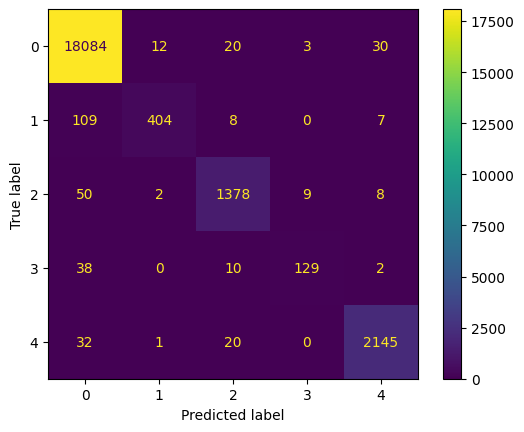

In [59]:
cm = confusion_matrix(y_test, predicts)
ConfusionMatrixDisplay(cm).plot()

In [60]:
# Get Accuracy, macro Precision, macro Recall, macro F1 and macro sensitivity from confusion matrix
def get_metrics_from_cm(confusion_matrix, num_classes):
  precisions = []
  recalls = []
  sensitivities = []
  for i in range(num_classes):
    TP = confusion_matrix[i, i]
    FP = np.sum(confusion_matrix[:, i]) - TP  # Sum of column i minus the diagonal element
    FN = np.sum(confusion_matrix[i, :]) - TP  # Sum of row i minus the diagonal element

    # Calculate precision and recall for class i
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero
    sensitivity_i = TP / (TP + FN) if (TP + FN) != 0 else 0 # Avoid division by zero
    precisions.append(precision_i)
    recalls.append(recall_i)
    sensitivities.append(sensitivity_i)

  # Calculate accuracy, macro-average precision, recall and f1
  accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
  macro_precision = np.mean(precisions)
  macro_recall = np.mean(recalls)
  macro_sensitivity = np.mean(sensitivities)
  macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)

  return accuracy, macro_precision, macro_recall, macro_f1, macro_sensitivity


num_classes = 5
cm = confusion_matrix(y_test, predicts)
result = get_metrics_from_cm(cm, num_classes)
print(f"Accuracy:          {np.round(result[0]*100, 2)}%")
print(f"Macro precision:   {np.round(result[1]*100, 2)}%")
print(f"Macro recall:      {np.round(result[2]*100, 2)}%")
print(f"Macro f1:          {np.round(result[3]*100, 2)}%")
print(f"Macro sensitivity: {np.round(result[4]*100, 2)}%")

Accuracy:          98.4%
Macro precision:   96.1%
Macro recall:      88.21%
Macro f1:          91.98%
Macro sensitivity: 88.21%


In [61]:
# Get Accuracy, weighted Precision, weighted Recall, weighted F1 and weighted sensitivity from confusion matrix
def get_weighted_metrics_from_cm(confusion_matrix, num_classes):
    precisions = []
    recalls = []
    f1_scores = []
    sensitivities = []
    class_support = []

    for i in range(num_classes):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[:, i]) - TP  # Sum of column i minus the diagonal element
        FN = np.sum(confusion_matrix[i, :]) - TP  # Sum of row i minus the diagonal element
        support_i = np.sum(confusion_matrix[i, :])  # Number of true instances of class i

        # Calculate precision, recall and sensitivity for class i
        precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0  # Avoid division by zero
        recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0  # Avoid division by zero
        sensitivity_i = TP / (TP + FN) if (TP + FN) != 0 else 0 # Avoid division by zero

        # Calculate F1 score for class i
        f1_i = 2 * (precision_i * recall_i) / (precision_i + recall_i) if (precision_i + recall_i) != 0 else 0

        # Append to lists
        precisions.append(precision_i)
        recalls.append(recall_i)
        f1_scores.append(f1_i)
        sensitivities.append(sensitivity_i)
        class_support.append(support_i)

    # Total number of samples
    total_samples = np.sum(confusion_matrix)

    # Calculate weighted metrics
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
    weighted_precision = np.sum(np.array(precisions) * np.array(class_support)) / total_samples
    weighted_recall = np.sum(np.array(recalls) * np.array(class_support)) / total_samples
    weighted_f1 = np.sum(np.array(f1_scores) * np.array(class_support)) / total_samples
    weighted_sensitivity = np.sum(np.array(sensitivities) * np.array(class_support)) / total_samples

    return accuracy, weighted_precision, weighted_recall, weighted_f1, weighted_sensitivity



num_classes = 5
cm = confusion_matrix(y_test, predicts)
result = get_weighted_metrics_from_cm(cm, num_classes)
print(f"Accuracy:             {np.round(result[0]*100, 2)}%")
print(f"Weighted precision:   {np.round(result[1]*100, 2)}%")
print(f"Weighted recall:      {np.round(result[2]*100, 2)}%")
print(f"Weighted f1:          {np.round(result[3]*100, 2)}%")
print(f"Weighted sensitivity: {np.round(result[4]*100, 2)}%")

Accuracy:             98.4%
Weighted precision:   98.37%
Weighted recall:      98.4%
Weighted f1:          98.35%
Weighted sensitivity: 98.4%


# **7. Saving Model**

In [ ]:
torch.save(model.state_dict(), "ecg_heartbeat_classfication_model")

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }, "complete_ecg_heartbeat_classfication_model")